In [806]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd
import pytz
import glob
import datetime as dt
import matplotlib.dates as mdates
import xarray as xr
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.interpolate import interp1d
############################################
#mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
############################################

In [488]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

you have 12 wind profiles to plot


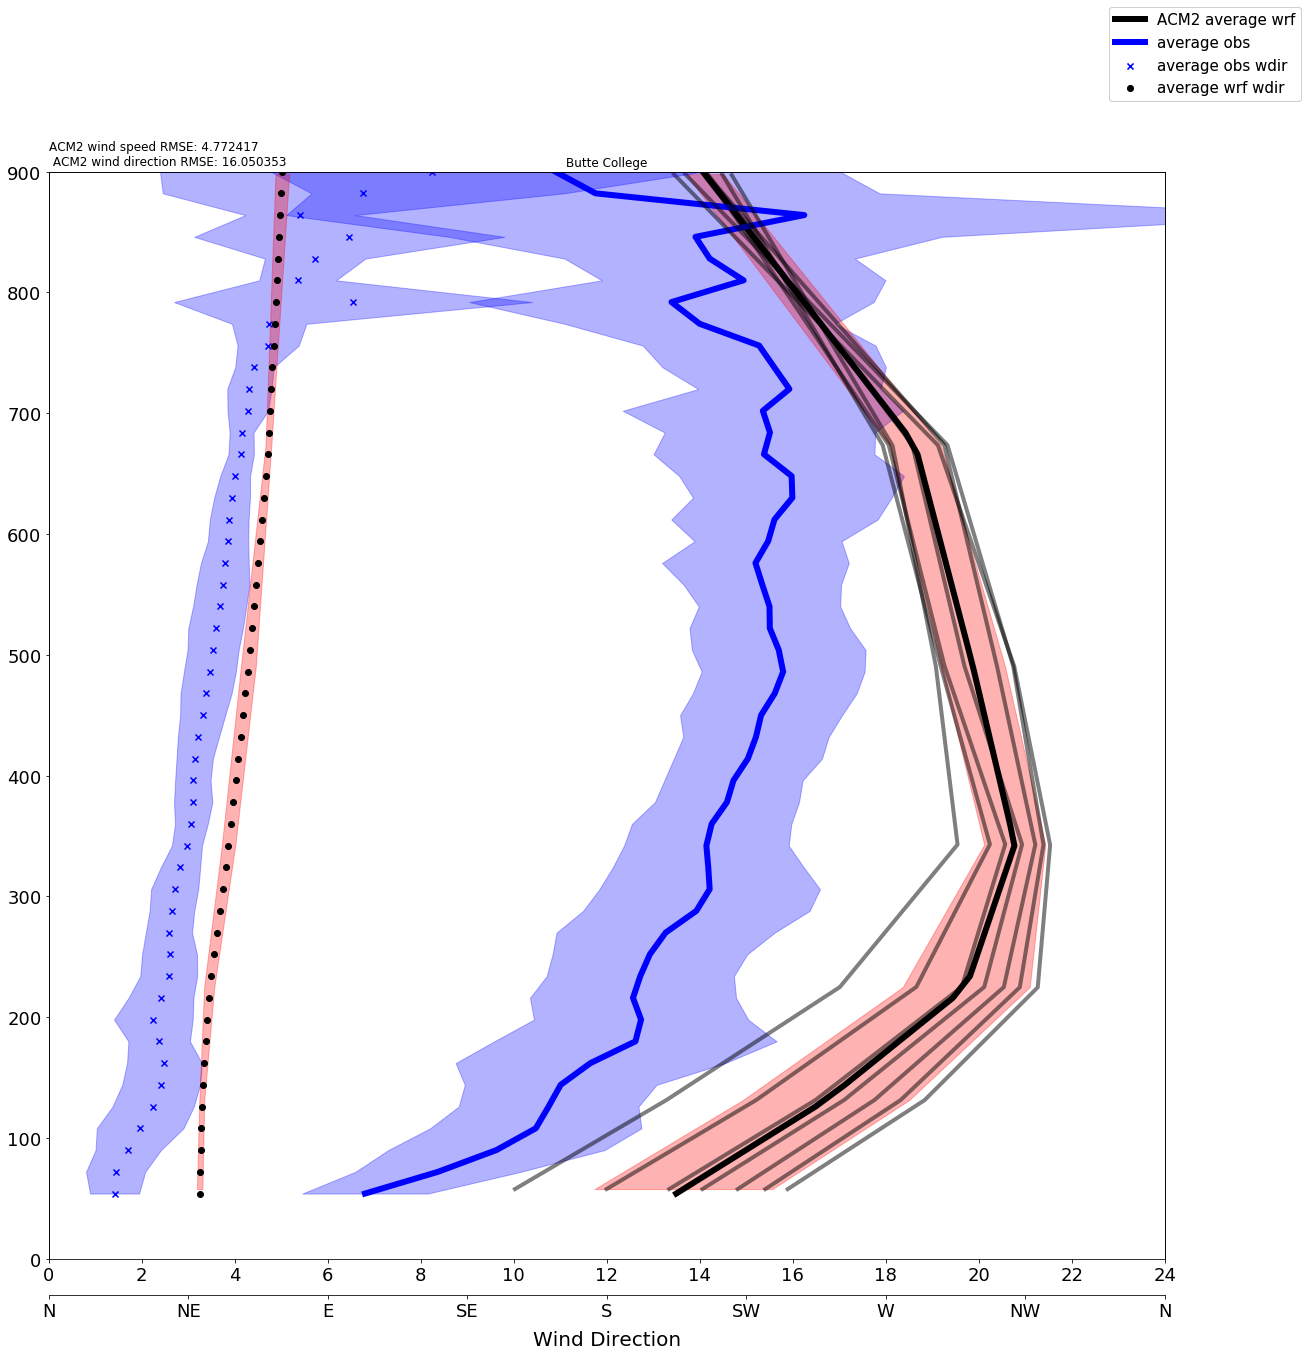

In [893]:

#Prepping Files For Import
path =r'/export/home/mbrewer/Documents/campfire/stares/20181109' # use your path
allFiles = glob.glob(path + "/Processed_Wind_Profile_19_20181109_05*.hpl")
print ('you have %s wind profiles to plot' %(len(allFiles)))
dim1 = len(allFiles)
time_ar = np.zeros((dim1), dtype='datetime64[ns]')
for k,i in enumerate(allFiles,0): #pull time from import dictionaries and append to list
    df = pd.read_csv(i, skiprows = 1, sep = '\s+', names = names)
    height = np.array(df.height).reshape(300)
    t= str(i[-19:-4])
    time = pd.to_datetime(t, format = '%Y%m%d_%H%M%S')
    time_ar[k] = np.datetime64(time)
    if k ==0:
        spd_matrix = np.zeros((dim1,len(height)))
        dir_matrix = np.zeros((dim1,len(height)))
    spd_matrix[k] = df.wspd
    dir_matrix[k] = df.wdir
ld = xr.Dataset(coords = {'hgt':(['y'], height),'time':(['x'],time_ar) })
ld['wspd'] = (['time','hgt'], spd_matrix)
ld['wdir'] = (['time', 'hgt'], dir_matrix)
ld_wspd_av = ld.wspd[3:].mean(dim='time')
ld_wdir_av = ld.wdir[3:].mean(dim= 'time')
ld_wspd_std = ld.wspd[3:].std(dim='time')
ld_wd_std = ld.wdir[3:].std(dim='time')

ds = xr.open_dataset('Final_butte_lidar_scm.nc')
wrf = ds.sel(Time=slice('2018-11-09 05:00:00', '2018-11-09 06:00:00'))
wspd_a = wrf.wspd[:,1:8].mean(dim = 'Time')
wdir_a = wrf.wdir[:,1:8].mean(dim = 'Time')
wspd_std = wrf.wspd[:,1:8].std(dim = 'Time')
wdir_std = wrf.wdir[:,1:8].std(dim = 'Time')
zz =wrf.z[:,1:8].mean(dim='Time')-wrf.z[:,0].mean(dim='Time')

interpolation_function = interpolate.interp1d(zz.data, wspd_a.data,fill_value="extrapolate")
new_x = ld.hgt.values[3:51]
wspd_int = interpolation_function(new_x)

interpolation_function = interpolate.interp1d(zz.data, wdir_a.data, fill_value="extrapolate")
wdir_int = interpolation_function(new_x)


fig, ax = plt.subplots(figsize = (20,20),) 
ax2 = ax.twiny()
ax.plot(wspd_int,new_x, label = 'ACM2 average wrf', color = 'k', linewidth = 6)
ax.plot( ld_wspd_av[3:51], ld.hgt.values[3:51], label = 'average obs', color = 'b', linewidth = 6)
ax.fill_betweenx(ld.hgt.values[3:51], ld_wspd_av.values[3:51] - ld_wspd_std.values[3:51], ld_wspd_av.values[3:51] + ld_wspd_std.values[3:51],
                 color='blue', alpha=0.3)
ax2.fill_betweenx(ld.hgt.values[3:51], ld_wdir_av.values[3:51] - ld_wd_std.values[3:51], ld_wdir_av.values[3:51] + ld_wd_std.values[3:51],
                 color='blue', alpha=0.3)
ax.fill_betweenx(zz, wspd_a.values - wspd_std.values, wspd_a.values + wspd_std.values,
                 color='red', alpha=0.3)
ax2.fill_betweenx(zz, wdir_a.values - wdir_std.values, wdir_a.values + wdir_std.values,
                 color='red', alpha=0.3)
for i in range(len(wrf.Time)):
    ax.plot(wrf.wspd[i,1:8], wrf.z[i,1:8]-wrf.z[i,0], linewidth = 4, color = 'k', alpha = .5)
ax2.scatter(ld_wdir_av[3:51], ld.hgt.values[3:51], marker = 'x', label = 'average obs wdir', color = 'b')
ax2.scatter(wdir_int, new_x, marker = 'o', label = 'average wrf wdir', color = 'k')
fig.legend(fontsize = 15)
ax.grid()
ax.set_ylim(0,ld.hgt.values[3:51][-1])
ax.set_xlim(0,25)
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(0,360)
ax2.set_xlabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax2.set_xticklabels(['','N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])
ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=2.0))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=100.0))
fig.legend(fontsize = 15)
ax.grid()
#ax.set_ylim(0,ld.hgt.values[3:51][-1])
ax.set_xlim(0,24)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18)
ax.set_title('Butte College')
ax.set_title('ACM2 wind speed RMSE: %f \n ACM2 wind direction RMSE: %f '%( rmse(ld_wspd_av[3:51], wspd_int),rmse(ld_wdir_av[3:51], wdir_int),), loc = 'left')
plt.savefig('acm2_mynn_ld_butte.png', dpi = 100)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


you have 8 wind profiles to plot


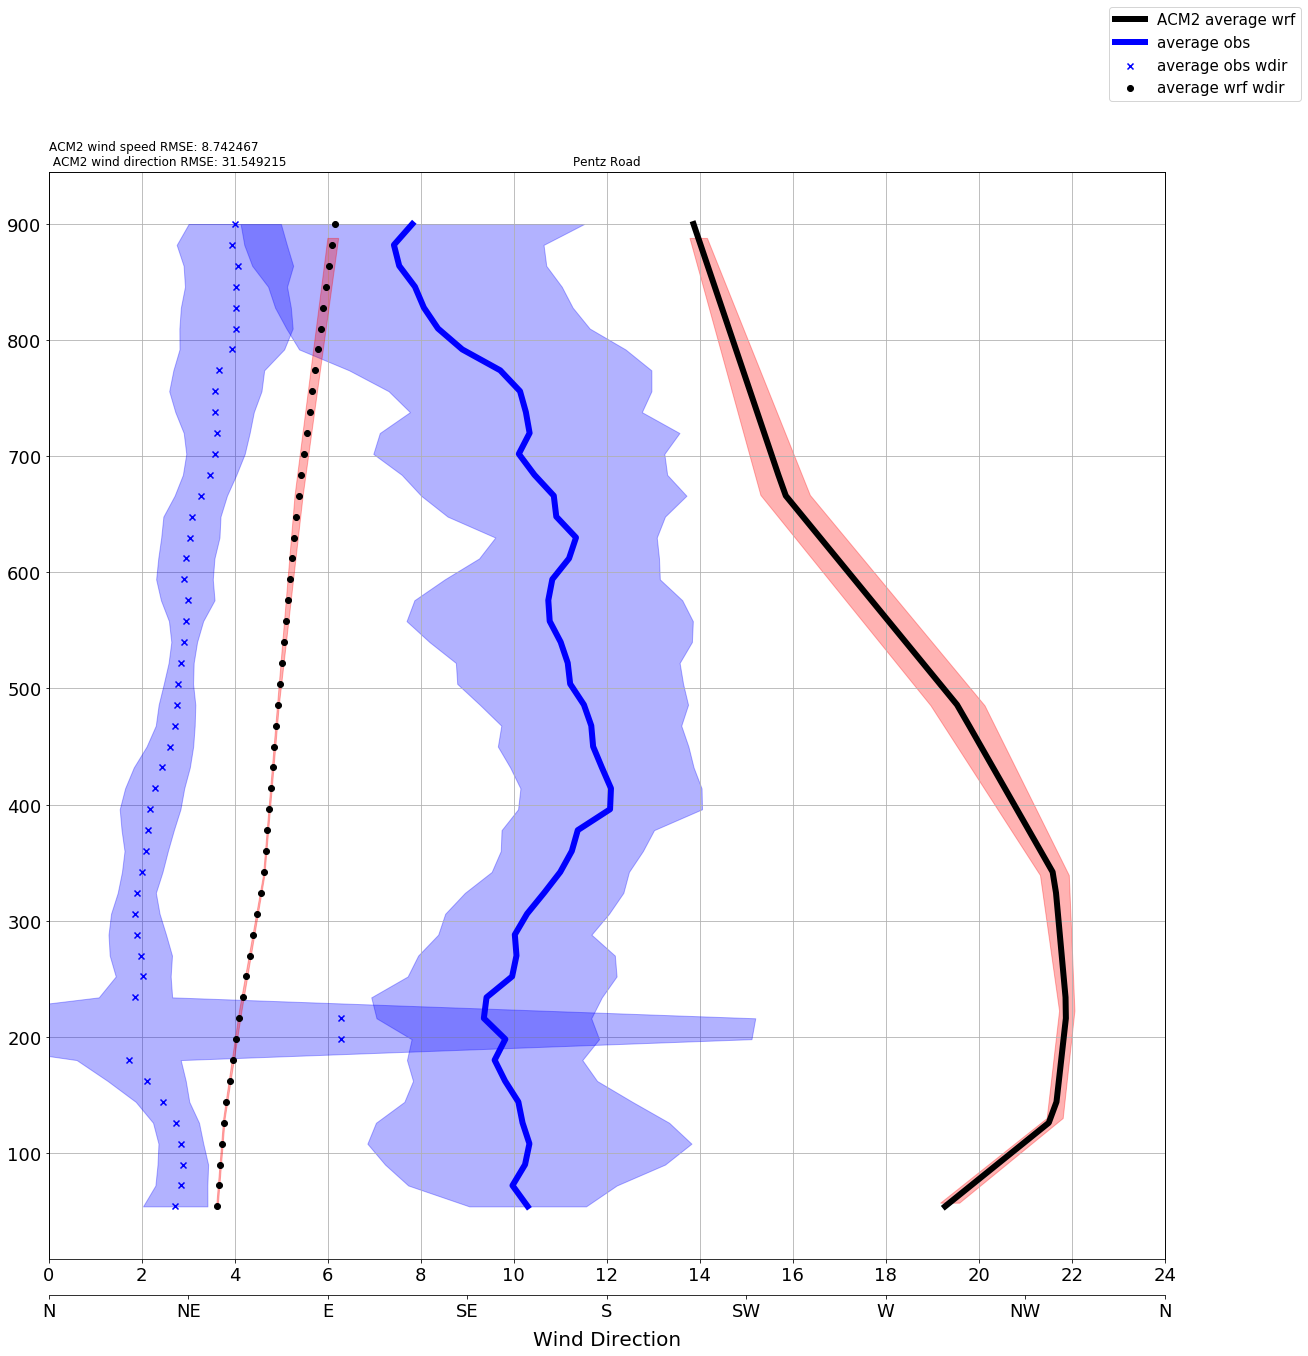

In [892]:

#Prepping Files For Import
path =r'/export/home/mbrewer/Documents/campfire/stares/20181109' # use your path
allFiles = glob.glob(path + "/Processed_Wind_Profile_19_20181109_03*.hpl")
print ('you have %s wind profiles to plot' %(len(allFiles)))
dim1 = len(allFiles)
time_ar = np.zeros((dim1), dtype='datetime64[ns]')
for k,i in enumerate(allFiles,0): #pull time from import dictionaries and append to list
    df = pd.read_csv(i, skiprows = 1, sep = '\s+', names = names)
    height = np.array(df.height).reshape(300)
    t= str(i[-19:-4])
    time = pd.to_datetime(t, format = '%Y%m%d_%H%M%S')
    time_ar[k] = np.datetime64(time)
    if k ==0:
        spd_matrix = np.zeros((dim1,len(height)))
        dir_matrix = np.zeros((dim1,len(height)))
    spd_matrix[k] = df.wspd
    dir_matrix[k] = df.wdir
ld = xr.Dataset(coords = {'hgt':(['y'], height),'time':(['x'],time_ar) })
ld['wspd'] = (['time','hgt'], spd_matrix)
ld['wdir'] = (['time', 'hgt'], dir_matrix)
ld_wspd_av = ld.wspd[3:].mean(dim='time')
ld_wdir_av = ld.wdir[3:].mean(dim= 'time')
ld_wspd_std = ld.wspd[3:].std(dim='time')
ld_wd_std = ld.wdir[3:].std(dim='time')

ds = xr.open_dataset('Final_pentz_road_lidar_scm.nc')
wrf = ds.sel(Time=slice('2018-11-09 03:00:00', '2018-11-09 03:40:00'))
wspd_a = wrf.wspd[:,1:8].mean(dim = 'Time')
wdir_a = wrf.wdir[:,1:8].mean(dim = 'Time')
wspd_std = wrf.wspd[:,1:8].std(dim = 'Time')
wdir_std = wrf.wdir[:,1:8].std(dim = 'Time')
zz =wrf.z[:,1:8].mean(dim='Time')-wrf.z[:,0].mean(dim='Time')

interpolation_function = interpolate.interp1d(zz.data, wspd_a.data,fill_value="extrapolate")
new_x = ld.hgt.values[3:51]
wspd_int = interpolation_function(new_x)

interpolation_function = interpolate.interp1d(zz.data, wdir_a.data, fill_value="extrapolate")
wdir_int = interpolation_function(new_x)


fig, ax = plt.subplots(figsize = (20,20),) 
ax2 = ax.twiny()
ax.plot(wspd_int,new_x, label = 'ACM2 average wrf', color = 'k', linewidth = 6)
ax.plot( ld_wspd_av[3:51], ld.hgt.values[3:51], label = 'average obs', color = 'b', linewidth = 6)
ax.fill_betweenx(ld.hgt.values[3:51], ld_wspd_av.values[3:51] - ld_wspd_std.values[3:51], ld_wspd_av.values[3:51] + ld_wspd_std.values[3:51],
                 color='blue', alpha=0.3)
ax2.fill_betweenx(ld.hgt.values[3:51], ld_wdir_av.values[3:51] - ld_wd_std.values[3:51], ld_wdir_av.values[3:51] + ld_wd_std.values[3:51],
                 color='blue', alpha=0.3)
ax.fill_betweenx(zz, wspd_a.values - wspd_std.values, wspd_a.values + wspd_std.values,
                 color='red', alpha=0.3)
ax2.fill_betweenx(zz, wdir_a.values - wdir_std.values, wdir_a.values + wdir_std.values,
                 color='red', alpha=0.3)
#for i in range(len(wrf.Time)):
#    ax.plot(wrf.wspd[i,1:8], wrf.z[i,1:8]-wrf.z[i,0], linewidth = 4, color = 'k', alpha = .5)
ax2.scatter(ld_wdir_av[3:51], ld.hgt.values[3:51], marker = 'x', label = 'average obs wdir', color = 'b')
ax2.scatter(wdir_int, new_x, marker = 'o', label = 'average wrf wdir', color = 'k')
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlim(0,360)
ax2.set_xlabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax2.set_xticklabels(['','N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])
ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=2.0))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=100.0))
fig.legend(fontsize = 15)
ax.grid()
#ax.set_ylim(0,ld.hgt.values[3:51][-1])
ax.set_xlim(0,24)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18);
for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(18)

ax.set_title('Pentz Road')
ax.set_title('ACM2 wind speed RMSE: %f \n ACM2 wind direction RMSE: %f '%( rmse(ld_wspd_av[3:51], wspd_int),rmse(ld_wdir_av[3:51], wdir_int),), loc = 'left')
plt.savefig('acm2_mynn_ld_pentz.png', dpi = 100)

(0, 1500)

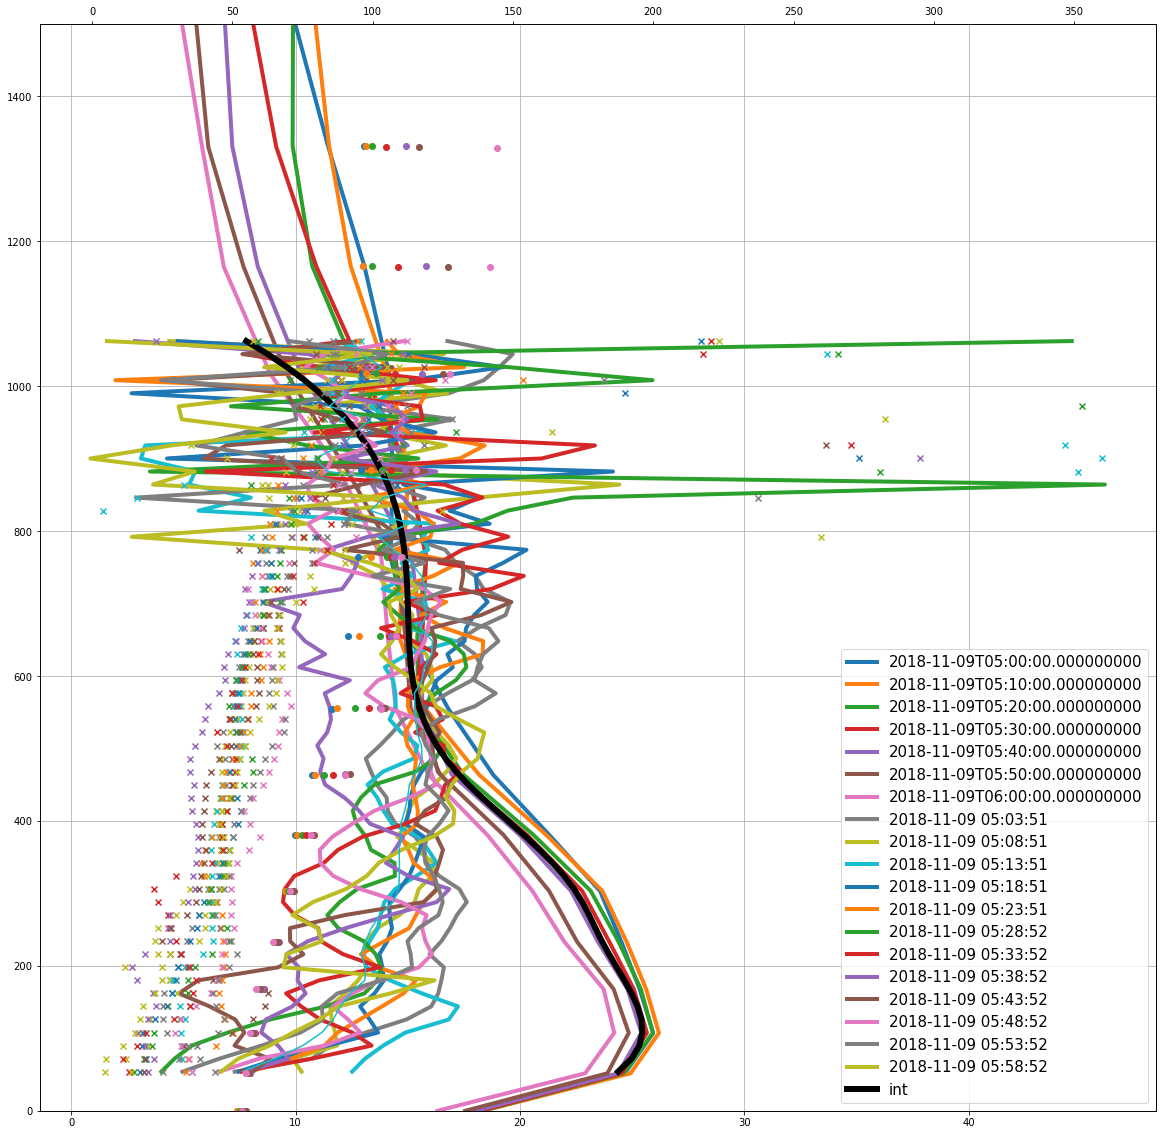

In [435]:
oro = xr.open_dataset('/srv/home/mbrewer/oro_profiler/oroville_profiller.nc')

ds = xr.open_dataset('Final_oro_pro_scm.nc')
wrf = ds.sel(Time=slice('2018-11-08 12:00:00', '2018-11-09 12:00:00'))
wspd_a = wrf.wspd[:,1:8].mean(dim = 'Time')
wdir_a = wrf.wdir[:,1:8].mean(dim = 'Time')
wspd_std = wrf.wspd[:,1:8].std(dim = 'Time')
wdir_std = wrf.wdir[:,1:8].std(dim = 'Time')
zz =wrf.z[:,1:8].mean(dim='Time')-wrf.z[:,0].mean(dim='Time')

interpolation_function = interpolate.interp1d(zz.data, wspd_a.data,fill_value="extrapolate")
new_x = ld.hgt.values[3:51]
wspd_int = interpolation_function(new_x)

interpolation_function = interpolate.interp1d(zz.data, wdir_a.data, fill_value="extrapolate")
wdir_int = interpolation_function(new_x)


fig, ax = plt.subplots(figsize = (20,20),) 
ax2 = ax.twiny()
ax.plot(wspd_int,new_x, label = 'ACM2 average wrf', color = 'k', linewidth = 6)
ax.plot( ld_wspd_av[3:51], ld.hgt.values[3:51], label = 'average obs', color = 'b', linewidth = 6)
ax.fill_betweenx(ld.hgt.values[3:51], ld_wspd_av.values[3:51] - ld_wspd_std.values[3:51], ld_wspd_av.values[3:51] + ld_wspd_std.values[3:51],
                 color='blue', alpha=0.3)
ax2.fill_betweenx(ld.hgt.values[3:51], ld_wdir_av.values[3:51] - ld_wd_std.values[3:51], ld_wdir_av.values[3:51] + ld_wd_std.values[3:51],
                 color='blue', alpha=0.3)
ax.fill_betweenx(zz, wspd_a.values - wspd_std.values, wspd_a.values + wspd_std.values,
                 color='red', alpha=0.3)
ax2.fill_betweenx(zz, wdir_a.values - wdir_std.values, wdir_a.values + wdir_std.values,
                 color='red', alpha=0.3)
#for i in range(len(wrf.Time)):
#    ax.plot(wrf.wspd[i,1:8], wrf.z[i,1:8]-wrf.z[i,0], linewidth = 4, color = 'k', alpha = .5)
ax2.scatter(ld_wdir_av[3:51], ld.hgt.values[3:51], marker = 'x', label = 'average obs wdir', color = 'b')
ax2.scatter(wdir_int, new_x, marker = 'o', label = 'average wrf wdir', color = 'k')
fig.legend(fontsize = 15)
ax.grid()
#ax.set_ylim(0,ld.hgt.values[3:51][-1])
ax.set_xlim(0,25)
ax2.set_xlim(0,360)
ax.set_title('Pentz Road')
ax.set_title('ACM2 wind speed RMSE: %f \n ACM2 wind direction RMSE: %f '%( rmse(ld_wspd_av[3:51], wspd_int),rmse(ld_wdir_av[3:51], wdir_int),), loc = 'left')
#plt.savefig('acm2_mynn_ld_pentz.png', dpi = 100)

In [582]:
dim1 = len(allFiles)
time_ar = np.zeros((dim1), dtype='datetime64[ns]')
for k,i in enumerate(allFiles,0): #pull time from import dictionaries and append to list
    df = pd.read_csv(i, skiprows = 1, sep = '\s+', names = names)
    height = np.array(df.height).reshape(300)
    t= str(i[-19:-4])
    time = pd.to_datetime(t, format = '%Y%m%d_%H%M%S')
    time_ar[k] = np.datetime64(time)
    if k ==0:
        spd_matrix = np.zeros((dim1,len(height)))
        dir_matrix = np.zeros((dim1,len(height)))
    spd_matrix[k] = df.wspd
    dir_matrix[k] = df.wdir
ds = xr.Dataset(coords = {'hgt':(['y'], height),'time':(['x'],time_ar) })
ds['wspd'] = (['time','hgt'], spd_matrix)
ds['wdir'] = (['time', 'hgt'], dir_matrix)

In [796]:
x,y = np.meshgrid(dss.z[1,0:13],dss.Time)

In [877]:
from scipy.interpolate import griddata
oro = xr.open_dataset('/srv/home/mbrewer/oro_profiler/oroville_profiller.nc')
oro_hgt = oro.hgt*1000
oro_av = oro.mean(dim='time')
oro_std = oro.std(dim='time')
ds = xr.open_dataset('Final_oro_pro_scm.nc')
dss = ds.sel(Time = np.array(oro.time.data, dtype = 'datetime64') ,method='nearest')

dss_av =ds.mean(dim = 'Time')

dss_std = dss.std(dim = 'Time')


interpolation_function = interpolate.interp1d(dss_av.z[0:13].data, dss_av.wspd[0:13].data,fill_value="extrapolate")

ds_wspd_int = interpolation_function(oro_hgt)


(0, 20)

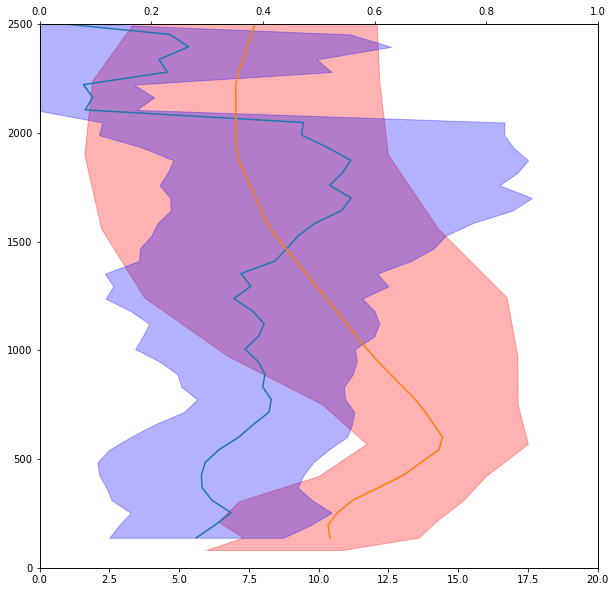

In [879]:
fig = plt.figure(figsize = (10,10))
ax=plt.subplot()
ax.plot(oro_av.wspd, oro_hgt)
ax.plot(ds_wspd_int, oro_hgt)

ax2 = ax.twiny()

ax.fill_betweenx(dss_av.z[0:13], dss_av.wspd[0:13] - dss_std.wspd[0:13], dss_av.wspd[0:13] + dss_std.wspd[0:13],
                 color='red', alpha=0.3)
ax.fill_betweenx(oro_hgt, oro_av.wspd - oro_std.wspd, oro_av.wspd + oro_std.wspd,
                 color='blue', alpha=0.3)

ax.set_ylim(0,2500)
ax.set_xlim(0,20)

In [841]:
d = ds.loc[dict(bottom_top=slice(0,13))]
dsi = d.interp(bottom_top =np.arange(0,42), Time = oro.time)

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

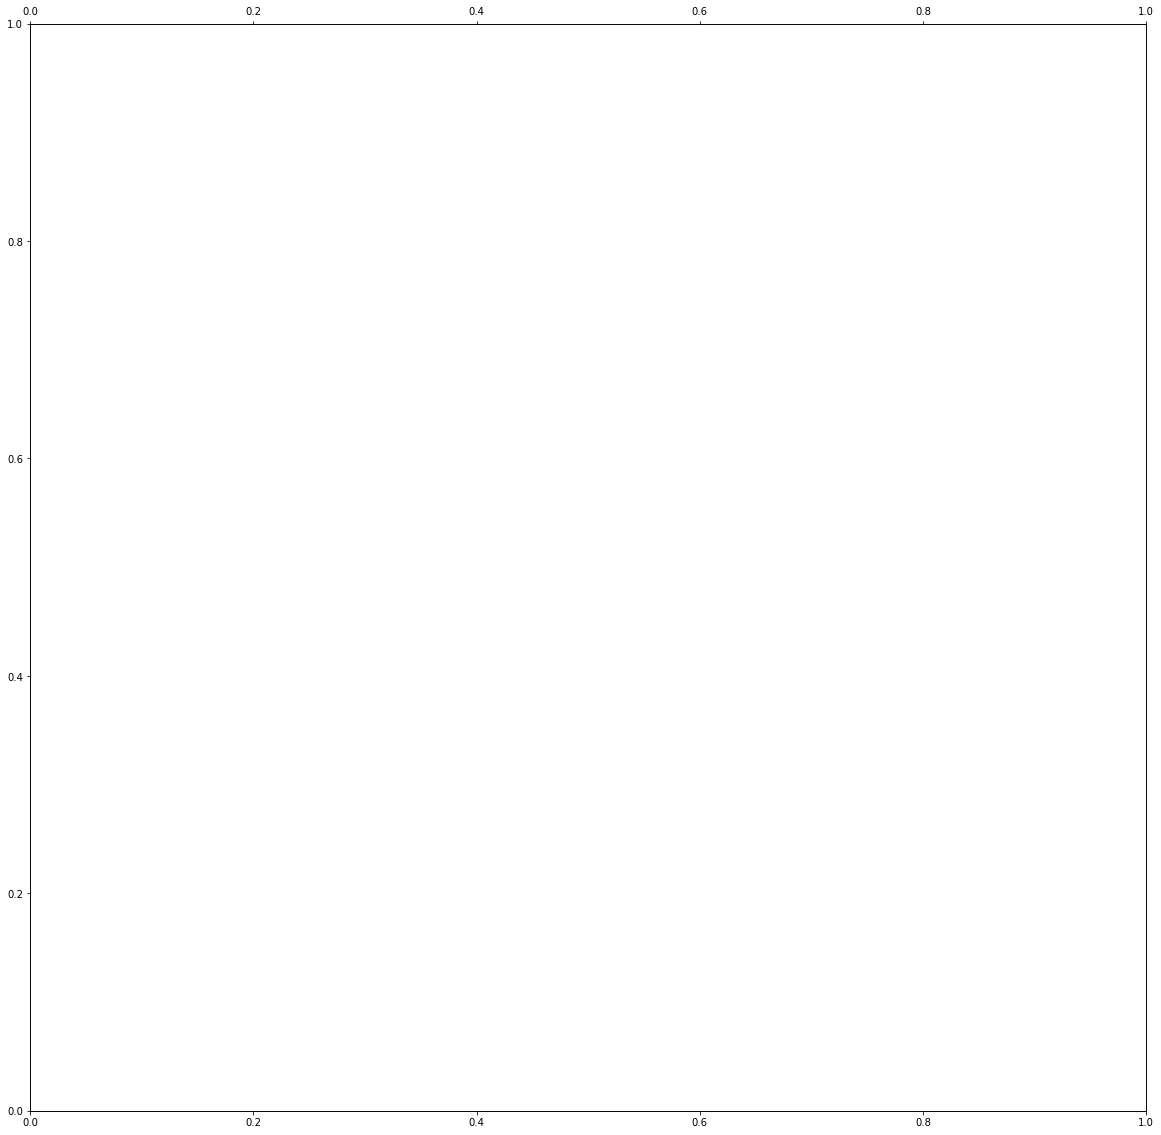

In [846]:
xi,yi = np.meshgrid(oro.hgt*1000,oro.time)
x,y = np.meshgrid(dsi.z,dsi.Time)
fig, ax = plt.subplots(figsize = (20,20),) 
ax2 = ax.twiny()

colors = plt.cm.bwr(np.linspace(0,1,len(oro.time)))
#for i in range(0,24):
#    ax.plot(oro.wspd[i], oro_hgt, linewidth = 3, color = colors[i])
   # ax.plot(ds.wspd.sel(Time = np.array(oro.time[i].data, dtype = 'datetime64')), ds.z[0], ls = '--', linewidth = 3, color = colors[i])

#a = ax.pcolormesh(yi,xi, oro.wspd)
#plt.colorbar(a)

b = ax.pcolormesh(y,x, dsi.wspd)
plt.colorbar(b)
fig.legend(fontsize = 15)
ax.grid()
#ax.set_ylim(0,2500)
#ax.set_xlim(0,25)
#ax2.set_xlim(0,360)
#ax.set_title('Pentz Road')
#ax.set_title('ACM2 wind speed RMSE: %f \n ACM2 wind direction RMSE: %f '%( rmse(ld_wspd_av[3:51], wspd_int),rmse(ld_wdir_av[3:51], wdir_int),), loc = 'left')
#plt.savefig('acm2_mynn_ld_pentz.png', dpi = 100)

<xarray.DataArray 'wspd' (time: 12, hgt: 300)>
array([[ 0.28,  0.71,  2.97, ...,  5.3 ,  7.53, 27.72],
       [ 0.2 ,  0.53,  2.73, ..., 12.93,  3.63, 26.95],
       [ 0.27,  0.34,  2.22, ..., 18.61, 13.17,  1.02],
       ...,
       [ 0.19,  0.54,  2.59, ...,  5.18,  7.04,  4.71],
       [ 0.14,  0.45,  2.51, ...,  8.2 ,  2.74,  9.12],
       [ 0.2 ,  0.39,  1.91, ...,  4.3 , 17.81,  4.18]])
Dimensions without coordinates: time, hgt